Metoda 1. Generowanie 100 punktów z przedziału [-100,100] 

In [ ]:
from random import uniform, randint
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from time import time
import math
import copy
from IPython import display
from IPython.display import HTML
from functools import cmp_to_key
from PIL import Image


# Zbiory podstawowe

In [ ]:
def First_generator(n=100):
    return [ (uniform(-100,100),uniform(-100,100)) for _ in range(n) ]

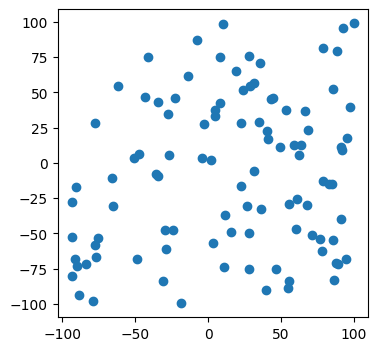

In [ ]:
points1 = First_generator()
plt.figure(figsize=(4,4))
plt.scatter(*zip(*points1))
# plt.show()
plt.savefig("100_from_100_to_100.png")

Metoda 2. Okrąg o promieniu 10 i centrum (0,0)

In [ ]:
def Second_generator(n=100):
    result = [ ]
    for _ in range(n):
        theta = uniform(0,2*np.pi)
        R = 10
        result.append((R*np.cos(theta),R*np.sin(theta)))
    return result

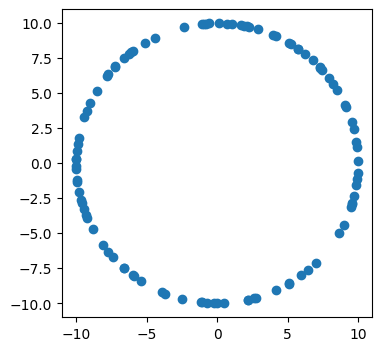

In [ ]:
points2 = Second_generator()
plt.figure(figsize=(4,4))
plt.scatter(*zip(*points2))
plt.savefig("Circle_of_radius_10_center_0,0.png")


Generator 3. Boki prostokąta 

In [ ]:
def Third_generator(n=100):
    result = []
    for _ in range(n):
        x = uniform(-10,10)
        if randint(0,2) % 2 == 0: 
            result.append((x,10*((-1)**randint(0,1))))
        else:
            result.append((10*((-1)**randint(0,1)),x))

    return result

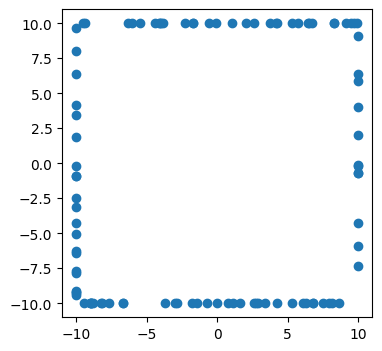

In [ ]:
points3 = Third_generator()
plt.figure(figsize=(4,4))
plt.scatter(*zip(*points3))
# plt.show()
plt.savefig("10x10_square.png")

In [ ]:
def Fourth_generator():
    result = [(0,0),(10,0),(0,10),(10,10)]
    for _ in range(25):
        x = uniform(0,10)
        if randint(0,2) % 2 == 0: 
            result.append((x,0))
        else:
            result.append((0,x))
    for _ in range(20):
        x = uniform(0,10)
        orientation = randint(0,1)
        result.append((x,10*orientation+x*(-1)**orientation))
    return result

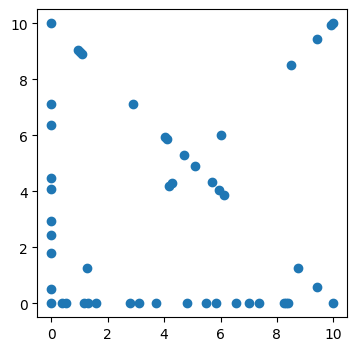

In [ ]:
points4 = Fourth_generator()
plt.figure(figsize=(4,4))
plt.scatter(*zip(*points4))
plt.savefig("4_corners_OX_OY_diagonal.png")

# Funkcje do zapisywania i wizualizacji danych

In [17]:
def create_tex_table(table_name,data):
    
    latex_template = r"""
\begin{table}[H]
    \renewcommand{\tablename}{Tabela}

    \centering
    \small
    \caption{Tabela różnic czasów obliczeń}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{@{}lllc@{}}
        \toprule
                Ilość punktów & Algorytm Grahama &  Algorytm Jarvisa & Punkty na otoczce wypukłej 
        \\ \midrule
"""
    
    def wrap(number):
        return str(round(number,4)).replace('.',',')
    for row in data:
        value_G = row['Graham']
        value_J = row['Jarvis']
        unit_G = ' \\mu s'
        unit_J = ' \\mu s'
        if int(value_G) >= 1000:
            unit_G = ' ms'
            value_G /= 1000
        if int(value_J) >= 1000:
            unit_J = ' ms'
            value_J /= 1000
        if int(value_G) >= 1000:
            unit_G = ' s'
            value_G /= 1000
        if int(value_J) >= 1000:
            unit_J = ' s'
            value_J /= 1000

        graham_time = wrap(value_G) + unit_G
        jarvis_time = wrap(value_J) + unit_J
        latex_template += f"        {row['Name']} & {graham_time} & {jarvis_time} & {row['Points']}\\\\ \n"

    latex_template += r"""        \bottomrule
    \end{tabular}
}
    \label{table:generator4}
    \small
    \normalsize
\end{table}
"""

    output_filename = f"{table_name}.tex"
    with open(output_filename, "w") as f:
        f.write(latex_template)

    print(f"LaTeX table has been written to {output_filename}")


In [18]:
def csv_dump(table_name,data):
    
    content = "Ilość punktów dla zbioru; Czas obliczeń dla algorytmu Grahama;Czas obliczeń dla algorytmu Jarvisa;Punkty na otoczce\n"
    
    def wrap(number):
        return str(round(number,4)).replace('.',',')
    for row in data:
        value_G = row['Graham']
        value_J = row['Jarvis']
        graham_time = wrap(value_G)
        jarvis_time = wrap(value_J)
        content = content + f"{row['Name']};{graham_time};{jarvis_time};{row['Points']}\n"
    output_filename = f"{table_name}.csv"
    with open(output_filename, "w") as f:
        f.write(content)

    print(f"CSV data table has been written to {output_filename}")

def create_tex_table_n(table_name,data):
    
    latex_template = r"""
\begin{table}[H]
    \renewcommand{\tablename}{Tabela}

    \centering
    \small
    \caption{Tabela różnic czasów obliczeń dla algorytmu Grahama i Jarvisa dla zmodyfikowanego zbioru}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{@{}lllc@{}}
        \toprule
                Ilość punktów & Algorytm Grahama &  Algorytm Jarvisa & Punkty na otoczce wypukłej 
        \\ \midrule
"""
    def wrap(number):
        return str(round(number,4)).replace('.',',').replace(",0 ","")
    for row in data:
        value_G = row['Graham']
        value_J = row['Jarvis']
        unit_G = ' \\mu s'
        unit_J = ' \\mu s'
        if int(value_G) >= 1000:
            unit_G = ' ms'
            value_G /= 1000
        if int(value_J) >= 1000:
            unit_J = ' ms'
            value_J /= 1000
        if int(value_G) >= 1000:
            unit_G = ' s'
            value_G /= 1000
        if int(value_J) >= 1000:
            unit_J = ' s'
            value_J /= 1000

        graham_time = wrap(value_G) + unit_G
        jarvis_time = wrap(value_J) + unit_J
        latex_template += f"        {row['Name']} & {graham_time} & {jarvis_time} & {row['Points']}\\\\ \n"

    latex_template += r"""        \bottomrule
    \end{tabular}
}
    \label{table:generator4}
    \small
    \normalsize
\end{table}
"""

    output_filename = f"{table_name}.tex"
    with open(output_filename, "w") as f:
        f.write(latex_template)

    print(f"LaTeX table has been written to {output_filename}")


In [19]:

def show_dump_hull(points, hull, name, adder):
    plt.figure(figsize=(4,4))
    
    # Plot points not in the hull in black
    for point in points:
        if point not in hull:
            plt.plot(point[0], point[1], 'ko', zorder=1)
    
    n = len(hull)
    
    with open(f"{name}_{adder}.txt", 'w') as f:
        for i in range(n):
            f.write(f"From: {hull[i]} to {hull[(i+1)%n]}\n")
            print(f"From: {hull[i]} to {hull[(i+1)%n]}")
            
            x_values = [hull[i][0], hull[(i+1) % n][0]]
            y_values = [hull[i][1], hull[(i+1) % n][1]]
            
            plt.plot(x_values, y_values, 'b-',zorder=2)
    
    with open(f"{name}_{adder}_ans.txt", 'w') as f:
            for i in range(n):
                f.write(str(hull))

    hull_x, hull_y = zip(*hull)
    plt.scatter(hull_x, hull_y, color='green', marker='o',zorder=3) 
    plt.savefig(f"Graham_{name}_{adder}.png")
    plt.close()



In [20]:
E = 1e-20
frame_count = 0
generator = 0


# Funkcje pomocnicze

Punkt o minimalnym y i jak najmniejszym x

In [21]:
def get_min_index(points):
    min_point = (float('inf'),float('inf'))
    indx = 0
    for i,point in enumerate(points):
        if min_point[1] > point[1]:
            indx = i
            min_point = point
        elif min_point[1] == point[1]:
            if point[0] < min_point[0]:
                indx = i
                min_point = point
    return min_point, indx


Wyznacznik macierzy 2x2

In [ ]:
def det(a,b,c):
    return (b[0] - a[0]) * (c[1] - b[1]) - (b[1] - a[1]) * (c[0] - b[0])

Odległość kwadratowa, aby uniknąć niedokładności związanych z sqrt()

In [23]:
def squared_distance(a, b):
    return (a[0] - b[0])**2 + (a[1] - b[1])**2

def follows(prev, current, next,det_fun=det):
    d = det_fun(prev, current, next)
    if d < -E:
        return True  
    if d > E:
        return False
    return squared_distance(prev, current) < squared_distance(prev, next)


# Implementacja algorytmu Grahama

In [24]:
def cmp(a, b, c):
    result = -det(a, b, c)
    if abs(result) <= E:
        return squared_distance(a, b) - squared_distance(a, c)
    return result


def Graham_timed(points, det_fun=det):
    hull = []
    start = time()
    starting_point, index = get_min_index(points)
    points[0], points[index] = points[index], points[0]
    sorted_points = sorted(points, key=cmp_to_key(lambda middle, last: cmp(starting_point, middle, last)))
    hull = [starting_point, sorted_points[1]]
    for point in sorted_points[2:]:
        d = det_fun(hull[-2], hull[-1], point)
        while len(hull) > 1 and d <= E:
            hull.pop()
            if len(hull) <= 1:
                break
            d = det_fun(hull[-2], hull[-1], point)
        
        hull.append(point)
    finish = time()
    runtime = finish - start
    return hull, runtime

# Implementacja algorytmu Jarvisa

In [25]:
def follows(prev, current, next, det_fun=det):
    d = det_fun(prev, current, next)
    if d < -E: 
        return True
    if d > E:   
        return False
    return squared_distance(prev, current) < squared_distance(prev, next)

def choose_next_time(points, last, current, det_fun=det):
    act = current
    for point in points:
        if act == last or follows(last, act, point, det_fun=det_fun):
            act = point
    return act


def Jarvis_timed(points, det_fun=det):
    start = time()
    
    startPoint, index = get_min_index(points)
    hull = [startPoint]
    points[index], points[0] = points[0], points[index]
    current_point = startPoint
    while True:
        next_point = choose_next_time(points, hull[-1], current_point, det_fun=det_fun)
        if next_point == startPoint:
            break
        hull.append(next_point)
        current_point = next_point
    
    finish = time()
    runtime = finish - start
    return hull, runtime



In [ ]:
# Define multiple point sets for testing
points_set = [(points1,"Pierwszy"),(points2,"Drugi"),(points3,"Trzeci"),(points4,"Czwarty")]
data = []


for points, name in points_set:

    Graham_hull, time_g = Graham_timed(points)
    Jarvis_hull, time_j = Jarvis_timed(points)
    if len(Graham_hull) != len(Jarvis_hull):
        print("================ ROZBIEŻNOŚĆ ================")
        print(f"{len(Jarvis_hull)} {Jarvis_hull}")
        print(f"{len(Graham_hull)} {Graham_hull}")
    data.append({"Name":name , "Graham":time_g*1000000, "Jarvis":time_j*1000000,"Points":len(Graham_hull)})
    create_tex_table("Wyniki",data) 

# Zbieranie danych ze zbiorów zmodyfikowanych

In [ ]:
# Dla zwiększających się wartości n na przedziale [-1000,1000]
def First_generator_modified(n=100,x_interval=(-1000,1000),y_interval=(-1000,1000)):
    x_min, x_max = x_interval
    y_min, y_max = y_interval
    return [ (uniform(x_min,x_max),uniform(y_min,y_max)) for _ in range(n) ]

# points_set = []

# for i in range(2,7):
#     points_set.append((First_generator_modified(n=pow(10,i)),f"1e{i}"))

# data = []

# for points, name in points_set:
#     print(name)
#     Graham_hull, time_g = Graham_timed(points)
#     Jarvis_hull, time_j = Jarvis_timed(points)
#     if len(Graham_hull) != len(Jarvis_hull):
#         print("================ ROZBIEŻNOŚĆ ================")
#         print(Graham_hull)
#         print(Jarvis_hull) 
#     data.append({"Name":name , "Graham":time_g*1000, "Jarvis":time_j*1000,"Points":len(Jarvis_hull)})
#     create_tex_table_n("Wyniki_wykładniczo_1",data) 
#     csv_dump("Wyniki_wykładniczo_1",data)

# points_set = []

for i in range(10000,65000,5000):
    print(i)
    points_set.append((First_generator_modified(i),f"{i}"))

data = []

for points, name in points_set:
    print(name)
    Graham_hull, time_g = Graham_timed(points)
    Jarvis_hull, time_j = Jarvis_timed(points)
    if len(Graham_hull) != len(Jarvis_hull):
        print("================ ROZBIEŻNOŚĆ ================")
        print(Graham_hull)
        print(Jarvis_hull) 
    data.append({"Name":name , "Graham":time_g*1000000, "Jarvis":time_j*1000000, "Points":len(Jarvis_hull)})
    create_tex_table_n("Wyniki_liniowo_1",data) 
    csv_dump("Wyniki_liniowo_1",data)



In [ ]:
E = 1e-20
def Second_generator_modified(n=100,center=(100,100),R=3000):
    result = [ ]
    x_center, y_center = center
    for _ in range(n):
        theta = uniform(0,2*np.pi)
        result.append((x_center+R*np.cos(theta),y_center+R*np.sin(theta)))
    return result


points_set = []

data = []

points_set = [(Second_generator_modified(100),"100"), (Second_generator_modified(200),"200"),(Second_generator_modified(300),"300")]

for i in range(500,4000,500):
    points_set.append((Second_generator_modified(i),f"{i}"))


points_set.append((Second_generator_modified(6000),"6000"))
points_set.append((Second_generator_modified(10000),"10000"))

data = []

for points, name in points_set:
    print(name)
    Graham_hull, time_g = Graham_timed(points)
    Jarvis_hull, time_j = Jarvis_timed(points)
    data.append({"Name":name , "Graham":time_g*1000000, "Jarvis":time_j*1000000,"Points":len(Jarvis_hull)})
    create_tex_table_n("Wyniki_liniowo_2",data) 
    csv_dump("Wyniki_liniowo_2",data)



In [ ]:
#  wartości na przedziale [-1000,1000]
def Third_generator_modified(n=100,lowerLeft = (-1000,-1000),upperRight = (1000,1000)):
    x_min,y_min = lowerLeft
    x_max,y_max = upperRight 
    result = []
    dy = y_max - y_min
    dx = x_max - x_min
    for _ in range(n):
        point = uniform(0,2*dy+2*dx)
        if point <= dx:
            result.append((x_min+point,y_min))
        elif point <= dy + dx:
            result.append((x_max,y_min+point-dx))
        elif point <= 2*dx + dy:
            result.append((x_min+point-dx-dy,y_max))
        else:
            result.append((x_min,y_min+point-2*dx-dy))
    return result

# points_set = []

# for i in range(1,6):
#     points_set.append((Third_generator_modified(pow(10,i)),f"1e{i}"))

# data = []

# for points, name in points_set:
#     print(name)
#     Graham_hull, time_g = Graham_timed(points)
#     Jarvis_hull, time_j = Jarvis_timed(points)
#     if len(Graham_hull) != len(Jarvis_hull):
#         print("================ ROZBIEŻNOŚĆ ================")
#         print(Graham_hull)
#         print(Jarvis_hull) 
#     data.append({"Name":name , "Graham":time_g*1000, "Jarvis":time_j*1000,"Points":len(Jarvis_hull)})
#     create_tex_table_n("Wyniki_wykładniczo_3",data) 
#     csv_dump("Wyniki_wykładniczo_3",data)
E = 1e-20

points_set = []

for i in range(10000,65000,5000):
    print(i)
    points_set.append((Third_generator_modified(i),f"{i}"))

data = []

for points, name in points_set:
    print(name)
    Graham_hull, time_g = Graham_timed(points)
    Jarvis_hull, time_j = Jarvis_timed(points)
    data.append({"Name":name , "Graham":time_g*1000000, "Jarvis":time_j*1000000,"Points":len(Jarvis_hull)})
    create_tex_table_n("Wyniki_liniowo_3",data) 
    csv_dump("Wyniki_liniowo_3",data)



In [ ]:
#  wartości na przedziale [-1000,1000]
def Fourth_generator_modified(n=100,m=100,lowerLeft = (-1000,-1000),upperRight = (1000,1000)):
    x_min,y_min = lowerLeft
    x_max,y_max = upperRight 
    result = [(x_min,y_min),(x_min,y_max),(x_max,y_min),(x_max,y_max)]
    dy = y_max - y_min
    dx = x_max - x_min
    for _ in range(n):
        point = uniform(0,dy+dx)
        if point <= dx:
            result.append((x_min+point,y_min))
        else:
            result.append((x_min,y_min+point-dx))

    for _ in range(m):
        point = uniform(0,dy+dx)
        if point <= dx:
            result.append((x_min+point,y_min+point))
        else:
            result.append((x_min+(point-dx),y_max-(point-dx)))
            # continue
    return result

# Graham_visualized(Fourth_generator_modified())

# points_set = []

# for i in range(1,20):
#     points_set.append((Fourth_generator_modified(pow(2,i),pow(2,i)),f"1e{i}"))

# data = []

# for points, name in points_set:
#     print(name)
#     Graham_hull, time_g = Graham_timed(points)
#     Jarvis_hull, time_j = Jarvis_timed(points)
#     if len(Graham_hull) != len(Jarvis_hull):
#         print("================ ROZBIEŻNOŚĆ ================")
#         print(Graham_hull)
#         print(Jarvis_hull) 
#     data.append({"Name":name , "Graham":time_g*1000, "Jarvis":time_j*1000,"Points":len(Jarvis_hull)})
#     create_tex_table_n("Wyniki_wykładniczo_4",data) 
#     csv_dump("Wyniki_wykładniczo_4",data)

points_set = []


for i in range(10000,65000,5000):
    points_set.append((Fourth_generator_modified(i,int(i*5/4)),f"{i+int(i*5/4)}"))

data = []

for points, name in points_set:
    print(name)
    Graham_hull, time_g = Graham_timed(points)
    Jarvis_hull, time_j = Jarvis_timed(points)
    data.append({"Name":name , "Graham":time_g*1000000, "Jarvis":time_j*1000000,"Points":len(Jarvis_hull)})
    create_tex_table_n("Wyniki_liniowo_4",data) 
    csv_dump("Wyniki_liniowo_4",data)

### Wizualizacja algorytmów tworzenia otoczki wypukłej

W celu wizualizacji, należy uruchomić poniższe fragmenty kodu.

#### Kody kolorów

**Algorytm Grahama:**
- <span style="color:blue">**Niebieski**</span> - Punkt nie został rozważony
- <span style="color:red">**Czerwony**</span> - Punkt aktualnie rozważany
- <span style="color:black">**Czarny**</span> - Punkt nie należy do otoczki
- <span style="color:green">**Zielony**</span> - Punkt należy do aktualnej otoczki

**Algorytm Jarvisa:**
- <span style="color:blue">**Niebieski**</span> - Punkt nie został rozważony
- <span style="color:red">**Czerwony**</span> - Punkt aktualnie rozważany jako kandydat
- <span style="color:black">**Czarny**</span> - Punkt został wybrany jako należący do otoczki
- <span style="color:green">**Zielony**</span> - Punkt należy do aktualnej otoczki


# Wizualizacja aglorytmu Grahama

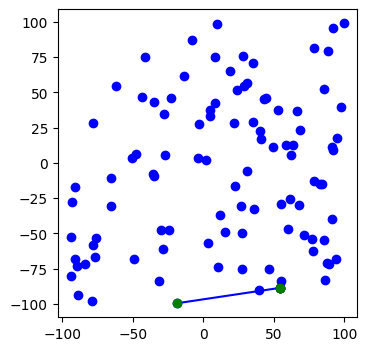

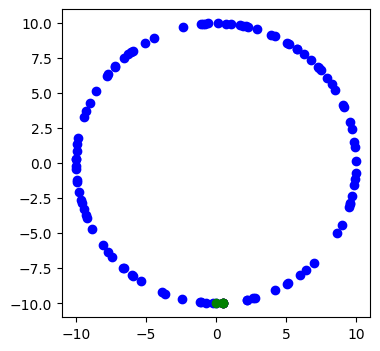

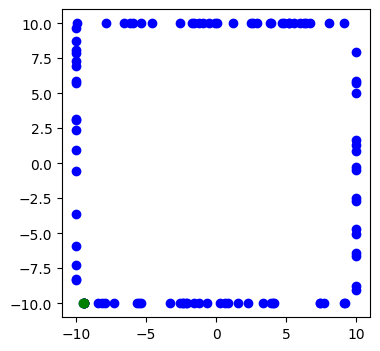

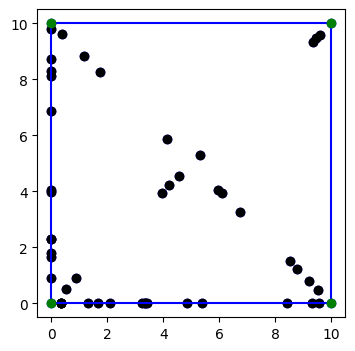

In [47]:
def Graham_visualized(points, det_fun=det):
    global frame_count
    global generator
    frame_count = 0
    result = []
    starting_point, index = get_min_index(points)
    points[0], points[index] = points[index], points[0]
    sorted_points = sorted(points, key=cmp_to_key(lambda middle, last: cmp(starting_point, middle, last)))
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_aspect('equal', 'box')
    for point in points:
        ax.plot(*point, 'bo', zorder=1)
    result = [starting_point, sorted_points[1]]
    p1, = ax.plot(*starting_point, 'go', zorder=3)
    p2, = ax.plot(*sorted_points[0], 'go', zorder=3)
    first_line, = ax.plot([starting_point[0], sorted_points[0][0]], [starting_point[1], sorted_points[0][1]], 'b-', zorder=2)
    
    lines_stack = [first_line]
    points_stack = [p1, p2]

    def update(frame):
        nonlocal result, lines_stack, points_stack
        if frame >= len(sorted_points[1:]):
            if len(result) > 1:
                last_line, = ax.plot([result[-1][0], result[0][0]], [result[-1][1], result[0][1]], 'b-', zorder=2)
                result.append(result[0]) 
            return lines_stack + points_stack

        point = sorted_points[frame + 1]
        red_point, = ax.plot(*point, 'ro', zorder=4)
        d = det_fun(result[-2], result[-1], point)
        
        while len(result) > 1 and d <= E:
            points_stack[-1].remove()
            lines_stack[-1].remove()
            lines_stack.pop()
            points_stack.pop()
            ax.plot(*result[-1], 'ko', zorder=1)
            result.pop()
            if len(result) <= 1:
                break
            d = det_fun(result[-2], result[-1], point)
        
        red_point.remove()
        line, = ax.plot([point[0], result[-1][0]], [point[1], result[-1][1]], 'b-', zorder=2)
        lines_stack.append(line)
        result.append(point)
        p, = ax.plot(*point, 'go', zorder=3)
        points_stack.append(p)
        
        return lines_stack + points_stack

    ani = animation.FuncAnimation(fig, update, frames=len(sorted_points), interval=300, repeat=False, blit=True)
    # plt.close(fig)
    
    return ani

points_set = [points1, points2, points3, points4]
animations = []

for points in points_set:
    animations.append(Graham_visualized(points))

# Można ustawić, którą animację ma wyświetlić program
HTML(animations[3].to_jshtml())


# Wizualizacja aglorytmu Jarvisa
Żeby uruchomić wizualizację algorytmu jarvisa, należy odpalić poniższą komórkę, niestety ale konwertowanie tego algorytmu na gif nie pokazywało, jak dobierane są kolejne punkty. Nie jestem w stanie ładnie wzizualizować tego algorytmu bez przepisywania wszystko na BIT-owy wizualizator.

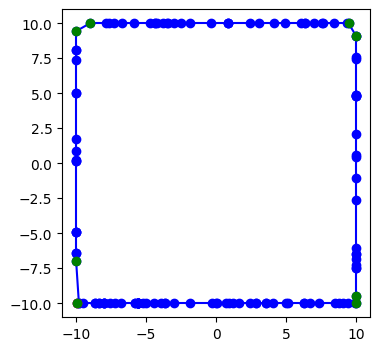

<Figure size 640x480 with 0 Axes>

In [15]:
from random import uniform, randint
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from time import time
import math
import copy
from IPython import display
from IPython.display import HTML
from functools import cmp_to_key
from PIL import Image

E = 1e-20
frame_count = 0
generator = 0

def det(a,b,c):
    return (b[0] - a[0]) * (c[1] - b[1]) - (b[1] - a[1]) * (c[0] - b[0])

def squared_distance(a, b):
    return (a[0] - b[0])**2 + (a[1] - b[1])**2

def follows(prev, current, next, det_fun):
    d = det_fun(prev, current, next)
    if d < -E:
        return True
    if d > E:
        return False
    return squared_distance(prev, current) < squared_distance(prev, next)

def Third_generator(n=100):
    result = []
    for _ in range(n):
        x = uniform(-10, 10)
        if randint(0, 2) % 2 == 0:
            result.append((x, 10 * ((-1)**randint(0, 1))))
        else:
            result.append((10 * ((-1)**randint(0, 1)), x))

    return result

points3 = Third_generator()

def get_min_index(points):
    min_point = (float('inf'), float('inf'))
    indx = 0
    for i, point in enumerate(points):
        if min_point[1] > point[1]:
            indx = i
            min_point = point
        elif min_point[1] == point[1]:
            if point[0] < min_point[0]:
                indx = i
                min_point = point
    return min_point, indx
def choose_next(points, last, current, fig, ax, det_fun=det):
    act = current
    prevline = None
    for point in points:
        p, = ax.plot(*point, 'ro', zorder=2)
        if act == last or follows(last, act, point, det_fun=det_fun):
            if act != current:
                ax.plot(*act, 'bo', zorder=1)
            line, = ax.plot([last[0], act[0]], [last[1], act[1]], 'b-', zorder=2)
            if prevline is not None:
                prevline.remove()
            prevline = line
            act = point
            display.clear_output(wait=True)
            display.display(fig)
            plt.draw()
            plt.pause(0.02)
        p.remove()
    if prevline is not None:
        prevline.remove()
    return act

def Jarvis_visualized(points, det_fun=det):
    points_set = copy.deepcopy(points)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_aspect('equal', 'box')

    # Initial points
    for point in points:
        ax.plot(*point, 'bo', zorder=1)

    start, index = get_min_index(points)
    points[index], points[0] = points[0], points[index]
    hull = [start]
    current_point = start
    ax.plot(*start, 'go', zorder=3)
    animation_frames = []

    def update(frame):
        nonlocal current_point, start
        next_point = choose_next(points_set, hull[-1], current_point, fig, ax, det_fun=det_fun)

        if next_point == start:
            line, = ax.plot([next_point[0], hull[-1][0]], [next_point[1], hull[-1][1]], 'b-', zorder=2)
            ax.plot(*next_point, 'go', zorder=3)
            animation_frames.append((fig,))
            return hull

        line, = ax.plot([next_point[0], hull[-1][0]], [next_point[1], hull[-1][1]], 'b-', zorder=2)
        hull.append(next_point)
        current_point = next_point
        ax.plot(*next_point, 'go', zorder=3)

        animation_frames.append((fig,))
        return hull
    ani = animation.FuncAnimation(fig, update, frames=7, interval=300, repeat=False, blit=False)

    plt.close(fig)
    return ani
points_set = [(points3, "Gen3")]
adder = "Jarvis"
animations = []
for points, fname in points_set:
    animations.append(Jarvis_visualized(points))

# Display the first animation
HTML(animations[0].to_jshtml())


## Zapisywanie do GIF

Poniższe fragmenty kodu zapisują powyższe animacje w formacie GIF

Combined GIF saved as Graham_animacja_wszstkich_zbiorów.gif


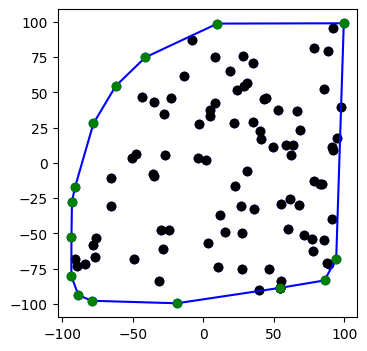

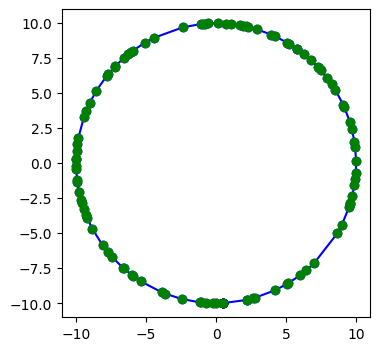

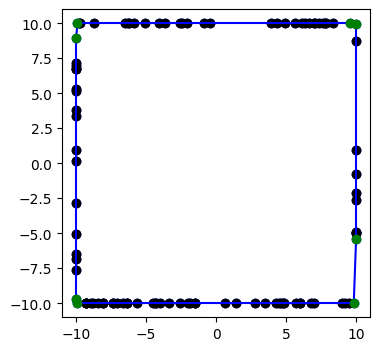

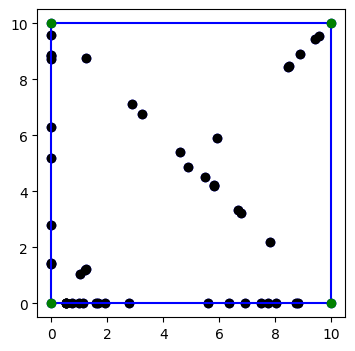

In [36]:

def Graham_visualized(points, det_fun=det):
    global frame_count
    frame_count = 0
    hull = []
    starting_point, index = get_min_index(points)
    points[0], points[index] = points[index], points[0]
    sorted_points = sorted(points, key=cmp_to_key(lambda middle, last: cmp(starting_point, middle, last)))
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_aspect('equal', 'box')
    for point in points:
        ax.plot(*point, 'bo', zorder=1)
    hull = [starting_point, sorted_points[1]]
    p1, = ax.plot(*starting_point, 'go', zorder=3)
    p2, = ax.plot(*sorted_points[0], 'go', zorder=3)
    first_line, = ax.plot([starting_point[0], sorted_points[0][0]], [starting_point[1], sorted_points[0][1]], 'b-', zorder=2)
    
    lines_stack = [first_line]
    points_stack = [p1, p2]

    def update(frame):
        nonlocal hull, lines_stack, points_stack
        if frame >= len(sorted_points[1:]):
            if len(hull) > 1:
                last_line, = ax.plot([hull[-1][0], hull[0][0]], [hull[-1][1], hull[0][1]], 'b-', zorder=2)
                hull.append(hull[0]) 
            return lines_stack + points_stack

        point = sorted_points[frame + 1]
        red_point, = ax.plot(*point, 'ro', zorder=4)
        d = det_fun(hull[-2], hull[-1], point)
        
        while len(hull) > 1 and d <= E:
            points_stack[-1].remove()
            lines_stack[-1].remove()
            lines_stack.pop()
            points_stack.pop()
            ax.plot(*hull[-1], 'ko', zorder=1)
            hull.pop()
            if len(hull) <= 1:
                break
            d = det_fun(hull[-2], hull[-1], point)
        
        red_point.remove()
        line, = ax.plot([point[0], hull[-1][0]], [point[1], hull[-1][1]], 'b-', zorder=2)
        lines_stack.append(line)
        hull.append(point)
        p, = ax.plot(*point, 'go', zorder=3)
        points_stack.append(p)
        
        return lines_stack + points_stack

    ani = animation.FuncAnimation(fig, update, frames=len(sorted_points), interval=300, repeat=False, blit=True)
    return ani

points_set = [points1, points2, points3, points4]
gif_filenames = []

for i, points in enumerate(points_set):
    ani = Graham_visualized(points)
    filename = f"Graham_nimacja_zbioru_{chr(i+ord('A'))}.gif"
    ani.save(filename, writer="pillow")
    gif_filenames.append(filename)

combined_gif = "Graham_animacja_wszstkich_zbiorów.gif"
frames = []

for gif in gif_filenames:
    gif_frames = Image.open(gif)
    while True:
        try:
            frames.append(gif_frames.copy())
            gif_frames.seek(gif_frames.tell() + 1)
        except EOFError:
            break

frames[0].save(
    combined_gif,
    save_all=True,
    append_images=frames[1:],
    duration=300,
    loop=0
)

print(f"Combined GIF saved as {combined_gif}")
